In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [14]:
df = pd.read_csv("titanic.csv")

In [15]:
# Заполнение пропусков
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Удалим Cabin (слишком много пропусков) и Ticket (неинформативный)
df.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1, inplace=True)

# Создание нового признака - семья (есть ли родственники на борту)
df['FamilySize'] = df['SibSp'] + df['Parch']
df['IsAlone'] = (df['FamilySize'] == 0).astype(int)

# Преобразование категориальных признаков
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

In [16]:
# Корреляции новых признаков с таргетом
corr_new = df.corr()['Survived'].sort_values(ascending=False)
print("Корреляции с таргетом:")
print(corr_new)

Корреляции с таргетом:
Survived      1.000000
Fare          0.257307
Parch         0.081629
FamilySize    0.016639
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.064910
Embarked_S   -0.149683
IsAlone      -0.203367
Pclass       -0.338481
Sex_male     -0.543351
Name: Survived, dtype: float64


### Анализ новых признаков:

### Гипотеза: пассажиры, путешествующие в одиночку (IsAlone = 1), должны выживать реже, так как им некому помочь в стрессовой ситуации

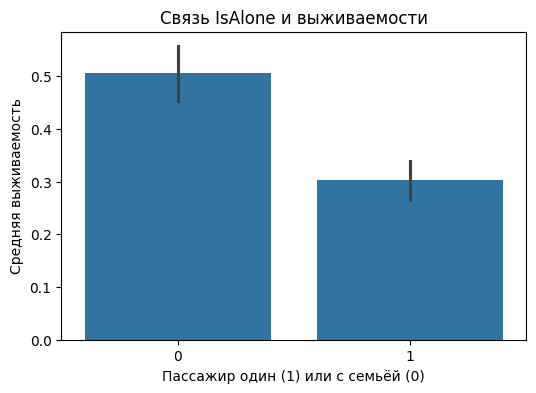

In [9]:
plt.figure(figsize=(6,4))
sns.barplot(x=df["IsAlone"], y=df["Survived"])
plt.title("Связь IsAlone и выживаемости")
plt.xlabel("Пассажир один (1) или с семьёй (0)")
plt.ylabel("Средняя выживаемость")
plt.show()

### Вывод: гипотеза подтверждается — пассажиры, путешествующие в одиночку, действительно выживали реже

### Гипотеза: большой размер семьи (FamilySize) может снижать шанс выживания, так как нужно спасать несколько людей одновременно

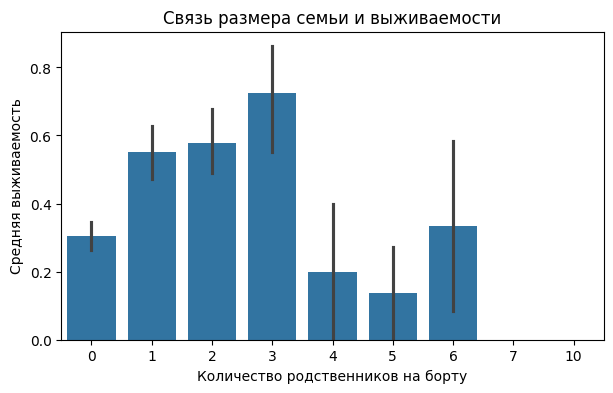

In [10]:
plt.figure(figsize=(7,4))
sns.barplot(x=df["FamilySize"], y=df["Survived"])
plt.title("Связь размера семьи и выживаемости")
plt.xlabel("Количество родственников на борту")
plt.ylabel("Средняя выживаемость")
plt.show()

### Вывод: тенденция подтверждается — очень большие семьи (3+) имели пониженную выживаемость

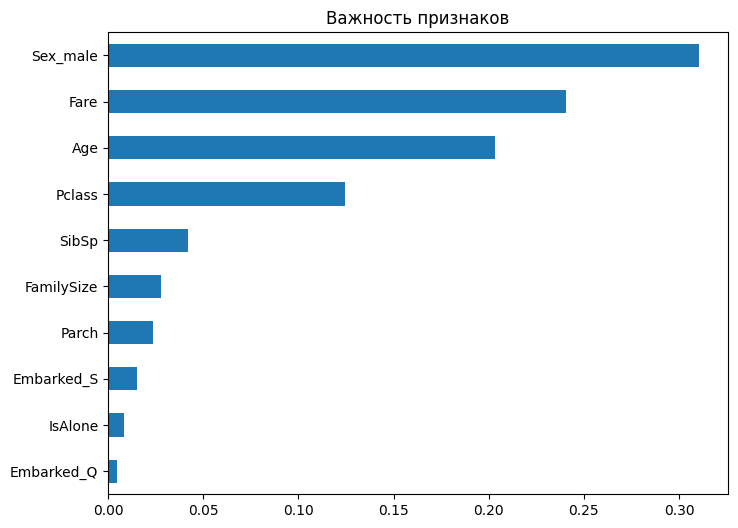

Accuracy дерева решений: 0.7821229050279329


In [5]:
# Визуализация важности признаков с помощью дерева решений
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

importances = pd.Series(tree.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6), title="Важность признаков")
plt.show()

print("Accuracy дерева решений:", accuracy_score(y_test, tree.predict(X_test)))

In [6]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Neural Network (MLP)": MLPClassifier(max_iter=500, random_state=42)
}

best_model = None
best_score = 0.0

print("Результаты кросс-валидации (5 фолдов):")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    std_score = scores.std()
    print(f"{name:25s}: {mean_score:.4f} ± {std_score:.4f}")
    if mean_score > best_score:
        best_score = mean_score
        best_model = name

print("\nЛучшая модель по точности на кросс-валидации:")
print(f"{best_model} с точностью {best_score:.4f}")

Результаты кросс-валидации (5 фолдов):
Logistic Regression      : 0.7935 ± 0.0210
Decision Tree            : 0.7733 ± 0.0309
Gradient Boosting        : 0.8272 ± 0.0242
Neural Network (MLP)     : 0.7924 ± 0.0363

Лучшая модель по точности на кросс-валидации:
Gradient Boosting с точностью 0.8272


### Итоговый вывод по моделям:

Лучшая модель: Gradient Boosting

Причины выбора:

Наивысшая точность на кросс-валидации, лучше остальных моделей

Устойчивость к выбросам и нелинейным зависимостям в данных

Хорошая работа на смешанных типах признаков

Недостатки:

Более высокая вычислительная стоимость по сравнению с логистической регрессией и деревьями